Symbols
TSLA    0.000714
BHP    -0.000248
TLS     0.005367
NVDA   -0.002946
AAPL   -0.000586
dtype: float64
[0.10061062 0.19013202 0.14943307 0.32401636 0.23580794]


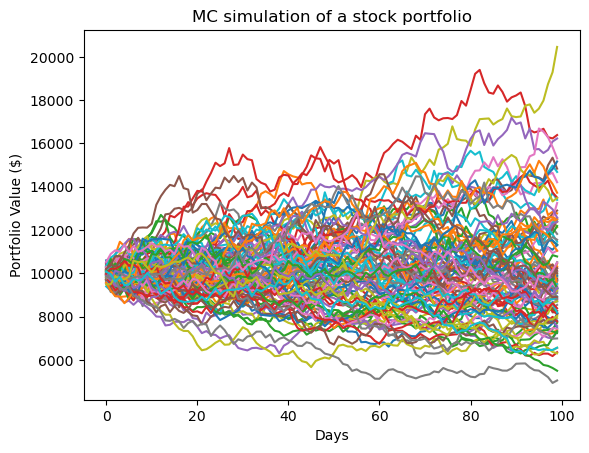

In [82]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt 
from scipy.stats import norm, t

# Importing Data form S&P 500: GSPC
def get_data(stocks, source, start, end):
    df = pdr.DataReader(stocks, source, start, end)
    stockData = df['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

stockList = ['TSLA', 'BHP', 'TLS', 'NVDA', 'AAPL']
stocks = [stock for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

returns, meanReturns, covMatrix = get_data(stocks, 'stooq', startDate, endDate)
print(meanReturns)

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)
print(weights)

# Monte Carlo Simulation
mc_sims = 100 # number of simulations
T = 100 # time in days 

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns).T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initial_portfolio = 10000

for m in range(0, mc_sims): 
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initial_portfolio
    
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [85]:
def mcVaR(returns, alpha=5): # Value at Risk
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")
        
def mcCVaR(returns, alpha=5): # Conditional Value at Risk
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
        
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initial_portfolio - mcVaR(portResults, alpha=5)
CVaR = initial_portfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR, 2)))
print('CVaR ${}'.format(round(CVaR, 2)))

VaR $3436.34
CVaR $4045.54
